### M6W9Project

#### Luke Barry

In [32]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
import nltk
# Importing the required library
from sklearn.feature_extraction.text import CountVectorizer
import langdetect
from stop_words import get_stop_words
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette('Set2')
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

### Load and inspect data

In [2]:
test = pd.read_csv(r'C:\Users\LukeB\Documents\ELU\w6 Project\test.csv')
train = pd.read_csv(r'C:\Users\LukeB\Documents\ELU\w6 Project\train.csv')
sample = pd.read_csv(r'C:\Users\LukeB\Documents\ELU\w6 Project\sample_submission.csv')

In [3]:
df=train

In [4]:
df.sample(10)

,id,keyword,location,text,target
5632,8032,refugees,NaN,A Turkish couple spent their wedding day feedi...,0
1998,2872,damage,Indonesia,'Mages of Fairy Tail.. Specialize in property ...,0
3163,4541,emergency,"Renfrew, Scotland",@batfanuk we enjoyed the show today. Great fun...,0
5667,8087,rescue,NaN,Last Chance Animal Rescue has 3 new posts. htt...,0
3469,4962,explosion,"London, UK",EE recalls Power Bar phone chargers after expl...,1
6710,9610,thunderstorm,NaN,Advice from Noah: Dont go running in a thunder...,0
4676,6647,inundation,NaN,Beyond all bounds; till inundation rise,0
4460,6343,hostages,NYC metro,Holmgren describing 96 World Cup: we were Lou'...,0
4761,6774,lightning,winston-salem north carolina,Expect gusty winds heavy downpours and lightni...,1
4195,5958,hazard,NaN,@DannyRaynard not bad personally I'd get rid o...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


***

### Data Cleaning

> The location and text data was quite messy. We will standardize it by removing all characters other than alphanumeric and convertring to lowercase.

In [6]:
# Cleaning string data
df['location'] = df['location'].str.replace(r'[^ \w+]', '').str.lower().str.replace(r'[ûª]', "").str.strip()
df['text'] = df['text'].str.replace(r'[^ \w+]', '').str.lower().str.replace(r'[ûª]', "").str.strip()
df[['text', 'location']].sample(20)

,text,location
817,blizzard of auz 9 pm cst radioriffrocks http...,canada
2777,i visited hiroshima in 2006 it is an incredibl...,washington dc
1593,im there bride amp groom on mountain cliff edg...,florida usa
3400,i eat because it makes my mouth explode with j...,london berlin online
6514,i will survive by gloria gaynor with oktaviana...,camberwell melbourne
7600,evacuation order lifted for town of roosevelt ...,NaN
332,so the ahamedis think the messiah had already ...,NaN
1640,the pain of those seconds must have been awful...,paris
3246,fnaf_talkmc stands there engulfed in the fire ...,NaN
18,my car is so fast,NaN


> Let's add a text_length column to inspect whether the length of the tweets can be used to determine if they are real or not.

In [7]:
# Previewing cleaning results
df['text_length'] = [len(i) for i in df['text']]
df[['text', 'text_length']].sample(5)

,text,text_length
3469,ee recalls power bar phone chargers after expl...,96
24,looooool,8
2999,how to survive a dust storm httptco0yl3yt4ylh,45
1563,beat the heat today only kill cliff free fall ...,117
2345,general news åêdemolition of houses on waterwa...,125


#### *Token Creation*
> This section tokenizes the words in the text and creates a column including the number of tokens in the text

In [8]:
# List comprehension to tokenize the reviews: the result is a list
tokens = [word_tokenize(text) for text in df['text']]

# Tokens will be a list of lists, where each inner list is a single review. Let's check whether that's indeed the case.
print('The first list of the tokens: ', tokens[0])

The first list of the tokens:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']


In [9]:
# We create an empty list for the length of tokens in each review, then loop over the tokens list, which remember is a list
# of lists, count how many tokens we have in each inner list and append it to the length_tokens. 
length_tokens = []
for item in range(len(tokens)):
    length_tokens.append(len(tokens[item]))

print(length_tokens[0], len(tokens[0]))
df['n_tokens']= length_tokens
#nw = pd.Series(length_tokens)
df.head()

13 13


,id,keyword,location,text,target,text_length,n_tokens
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,68,13
1,4,NaN,NaN,forest fire near la ronge sask canada,1,37,7
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,130,22
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,62,8
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,85,16


In [10]:
df.n_tokens.describe()

count    7613.000000
mean       14.584789
std         5.728332
min         1.000000
25%        10.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: n_tokens, dtype: float64

#### *Language Detection*
> This section inspects the languages of the tweets using language detect

In [11]:
langdetect.detect_langs(df.iloc[0, 3])

[en:0.9999992866917284]

In [12]:
languages = []

for i in range(len(df)):
        languages.append(str(langdetect.detect_langs(df.iloc[i,3])).split(':')[0][1:])

df['language'] = languages
df.language.value_counts()

en    7331
fr      28
ca      28
af      26
it      22
nl      21
sv      20
no      19
cy      15
da      15
et      10
ro      10
tl      10
es       9
hr       8
pl       6
so       6
pt       5
fi       5
sq       4
de       3
cs       3
sw       3
id       3
sl       2
sk       1
Name: language, dtype: int64

In [13]:
# Inspecting supposedly non english tweets
df.text[df['language'] != 'en'].sample(20)

165                             i had a airplane accident
2741                              keegan172 im devastated
1854            samel_samel has a crush httptcotbstk5vqu0
2795    metepec mexico  night disastereoficial  nitclu...
6884                     ianokavo96 hes still traumatised
1946                    da judge gave dis girl 5pm curfew
6697                                     thunder is legit
19                                 what a goooooooaaaaaal
6892                           wrongdejavu im traumatised
22                                            love skiing
5035                              urufusanragu a mudslide
6943                                   i feel so lucky rn
2717    zayn malik amp perrie edwards end engagement s...
1627    greeces tax revenues collapse as debt crisis c...
5503    officials alabama home quarantined over possib...
24                                               looooool
4728           httpstco4i0rkcbk1dson of savior lava video
5420          

> It appears that even the small amount of tweets that aren't categorized as english are simply miscategorized by langdetect. This makes the language column useless so I will drop it.

In [14]:
# Dropping Language column
df.drop('language', axis=1, inplace=True)

***

### EDA
> Let's explore the data and look for meaningful relaitonships between the columns

#### *Location*
> Let's take a look at where the tweets are coming from. We will focus on tweets with more than 10 mentions, since this filters out alot of the nonsenical locations.

In [15]:
# Separating low value locations into data frame with value counts
loc_val_count = df.location.value_counts().reset_index().rename(columns={"index": "location", "location": "count"}).query("count > 9").query("location != ''")
loc_val_count.tail()

,location,count
41,ss,10
42,denver colorado,10
43,dallas tx,10
44,new york city,10
45,san diego ca,10


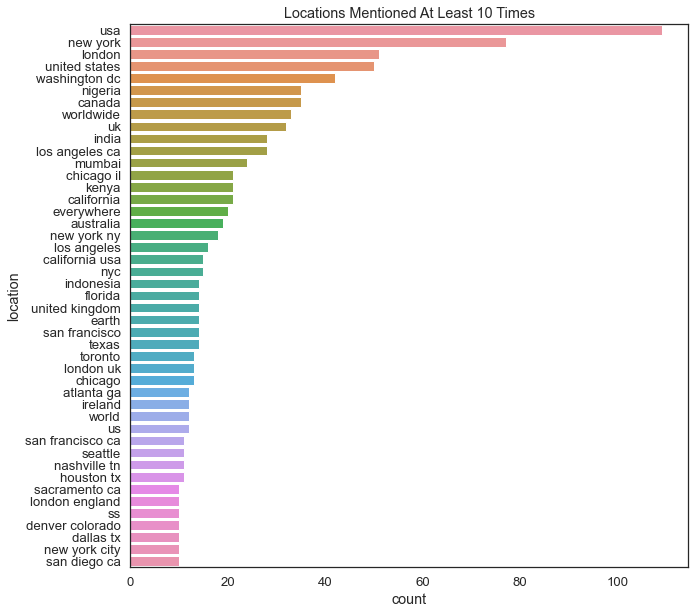

In [16]:
# Plotting
figure(figsize=(10, 10))
sns.barplot(x='count', y='location', data=loc_val_count)
plt.title('Locations Mentioned At Least 10 Times')
plt.show()

In [17]:
df.replace(0, 'not distaster').replace(1, 'disater')

,id,keyword,location,text,target,text_length,n_tokens
0,disater,NaN,NaN,our deeds are the reason of this earthquake ma...,disater,68,13
1,4,NaN,NaN,forest fire near la ronge sask canada,disater,37,7
2,5,NaN,NaN,all residents asked to shelter in place are be...,disater,130,22
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,disater,62,8
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,disater,85,16
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,disater,78,11
7609,10870,NaN,NaN,aria_ahrary thetawniest the out of control wil...,disater,121,20
7610,10871,NaN,NaN,m194 0104 utc5km s of volcano hawaii httptcozd...,disater,54,8
7611,10872,NaN,NaN,police investigating after an ebike collided w...,disater,132,19


#### *Keywords*
> This section takes a look at all of the keywords and their counts separated by real and not real disaster tweets. %20 represents a space.

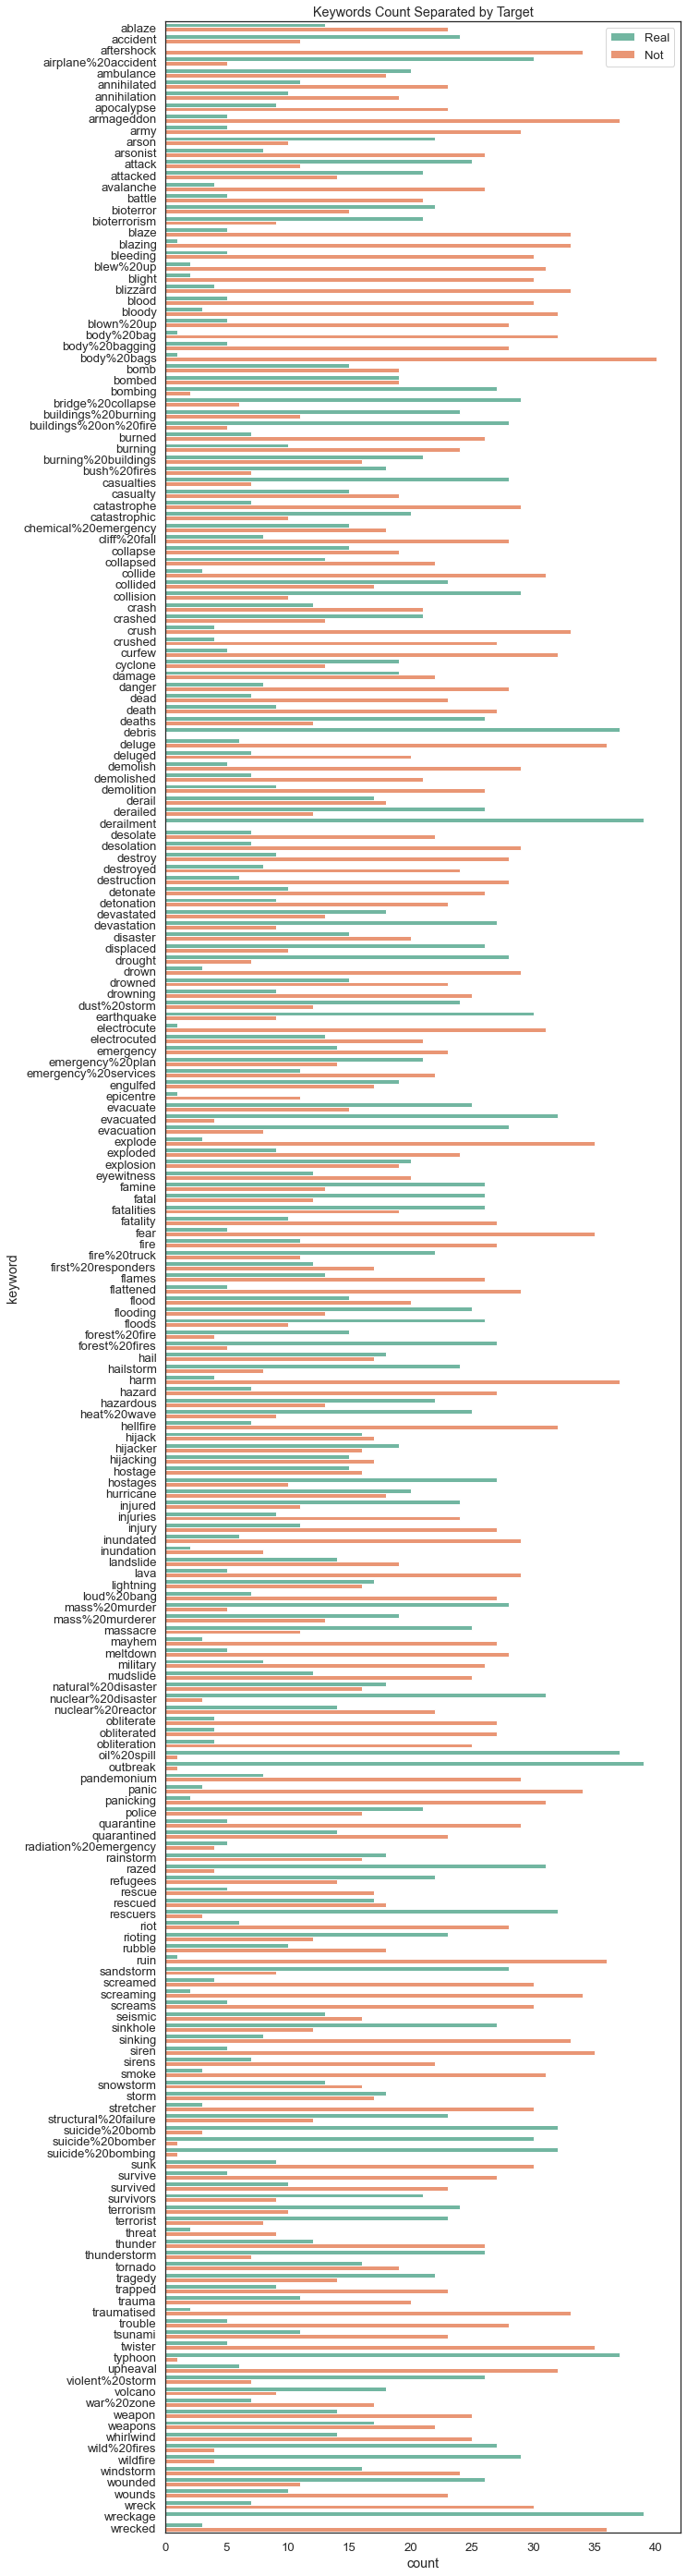

In [18]:
# Keyword count plot
figure(figsize=(10, 50))
sns.countplot(y='keyword', data=df.replace(0, 'Not').replace(1, 'Real'), hue='target')
plt.legend(loc='upper right')
plt.title('Keywords Count Separated by Target')
plt.show()

> This graph is a useful representation of how many words that seem like potential 'disaster' words can be and are being used in a different context on twitter.

#### *Token Count and Text Length*

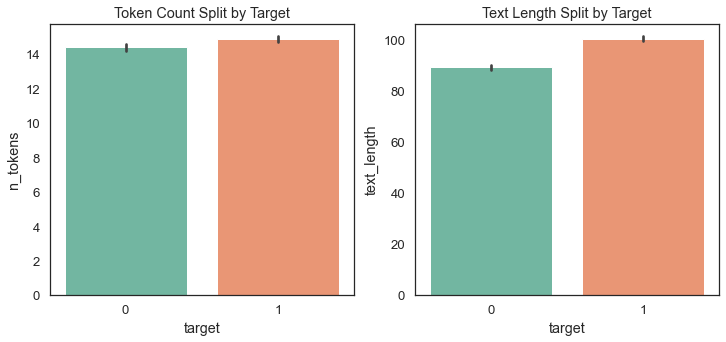

In [19]:
# Token count split by target
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

a = sns.barplot(x='target', y='n_tokens', data=df, ax=ax1)
a.set_title('Token Count Split by Target')

b = sns.barplot(x='target', y='text_length', data=df, ax=ax2)
b.set_title('Text Length Split by Target')

plt.show()

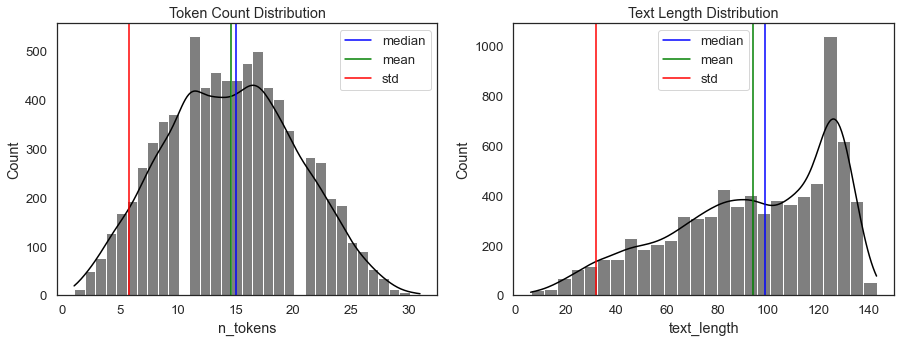

In [20]:
# Distribution plots
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

a = sns.histplot(df['n_tokens'], kde =True, color='black', ax=ax1)
median = a.axvline(df['n_tokens'].median(), color='b', linestyle='-')
mean = a.axvline(df['n_tokens'].mean(), color='g', linestyle='-')
std = a.axvline(df['n_tokens'].std(), color='r', linestyle='-')
a.set_title('Token Count Distribution')
a.legend([median, mean, std], ['median','mean','std'])
plt.title('Token Count and Text Length Distribution')

b = sns.histplot(df['text_length'], kde =True, color='black')
median = b.axvline(df['text_length'].median(), color='b', linestyle='-')
mean = b.axvline(df['text_length'].mean(), color='g', linestyle='-')
std = b.axvline(df['text_length'].std(), color='r', linestyle='-')
b.set_title('Text Length Distribution')
b.legend([median, mean, std], ['median','mean','std'])
plt.title('Text Length Distribution')

plt.show()

> There does not appear to be a clear difference between the lengths/token counts of target and non target data. The token count is usually somewhere between 9-21, and the text length appears to have a clear increrase as it approaches the maximum (140 characters), with very few actually reaching it. 

#### *Correlation Matrix*

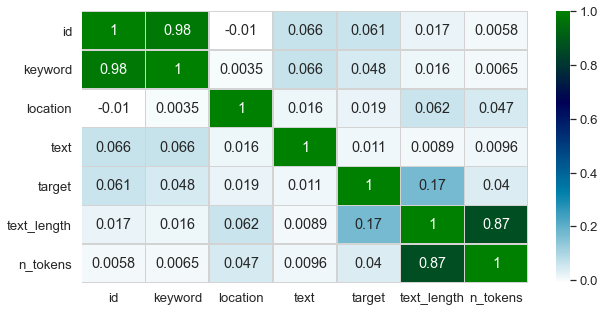

In [21]:
# Correlation Matrix
cat = df.copy()
for col in cat:
    cat[col] = cat[col].astype('category').cat.codes

figure(figsize=(10, 5))
sns.heatmap(cat.corr(), cmap='ocean_r', robust=True,  linecolor='lightgrey', linewidths=0.5, annot=True)
plt.show()

> Interestingly, there appears to be a higher correlation between text length and the target column than any other potentially meaningful pair.

***

### DF Prep for Model

In [22]:
# setting stop words
stop_words = set(get_stop_words('english'))

# initializing vectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words = stop_words).fit(df.text)

# transforming output
vect_trans = vectorizer.transform(df.text)

vect_trans

<7613x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 35578 stored elements in Compressed Sparse Row format>

In [23]:
# putting output into a database
X_df = pd.DataFrame(vect_trans.toarray() , columns = vectorizer.get_feature_names())
X_df.sample(10)

,05,10,100,11,11yearold,12,12000,13,15,16,...,year,years,yes,yet,york,young,youre,youth,youtube,zone
1358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# slicing for later concat

df_slice = df.drop(['id', 'text', 'keyword', 'location'], axis=1)
df_slice.head()

,target,text_length,n_tokens
0,1,68,13
1,1,37,7
2,1,130,22
3,1,62,8
4,1,85,16


In [25]:
# resetting index for proper concatination
df_slice.reset_index(drop=True, inplace=True)

In [26]:
# Concatenating the sliced and new datasets

model_df = pd.concat([X_df, df_slice], axis=1)
model_df.sample(10)

,05,10,100,11,11yearold,12,12000,13,15,16,...,yet,york,young,youre,youth,youtube,zone,target,text_length,n_tokens
3383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,112,19
2581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,89,14
2984,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,130,21
2649,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,47,6
7311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,133,26
6637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,85,13
2424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,94,20
2558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,107,14
6322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,90,13
2849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,103,17


***

### Comparing Models

#### *Training*

In [27]:
# specifying X and y
X = model_df.drop('target', axis=1)
y = model_df.target

## training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=100)

In [28]:
# Creating a function to evaluate pipelines
def evaluation(pipeline):
    pipe = pipeline
    pipe.fit(X_train, y_train)  

    # classreport
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('Score: ', pipe.score(X_test, y_test))
    
    N, train_score, val_score = learning_curve(pipeline, X_train, y_train, cv=6, scoring='f1',\
                                          train_sizes=np.linspace(0.1, 1, 10))
    plt.figure(figsize=(10,4))
    plt.plot(N, train_score.mean(axis=1), label='Train score')
    plt.plot(N, val_score.mean(axis=1), label='Validation score')
    plt.legend()
    plt.title(pipeline)
    

#### *Comparing*

In [29]:
# Creating Variables of different models
SVM = make_pipeline(StandardScaler(), SVC(random_state=0, gamma='auto'))
logreg= make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
ADABoost = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=0))

In [30]:
# Create dictionary containing models
dict_of_models = {'SVM':SVM, 'LogisticRegression':logreg,\
                  'AdaBoostClassifier': ADABoost}

SVM
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       871
           1       0.83      0.65      0.73       652

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523

Score:  0.7964543663821405
LogisticRegression
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       871
           1       0.75      0.69      0.72       652

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523

Score:  0.7695338148391333
AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       871
           1       0.85      0.50      0.63       652

    accuracy                           0.75      1523
   macro avg       0.78      0.7

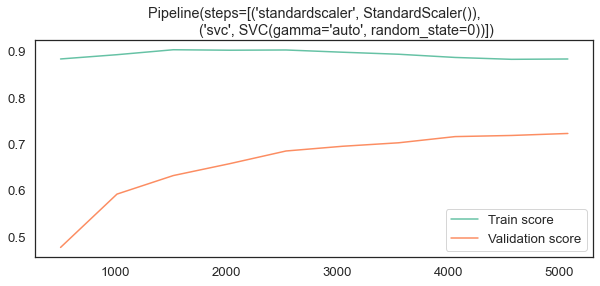

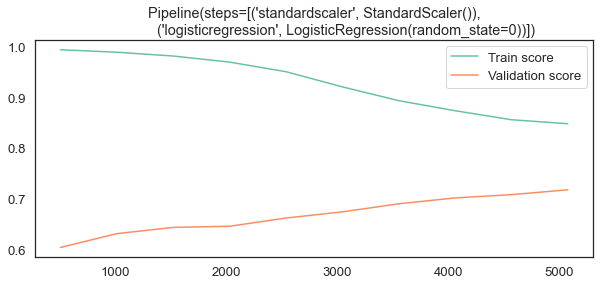

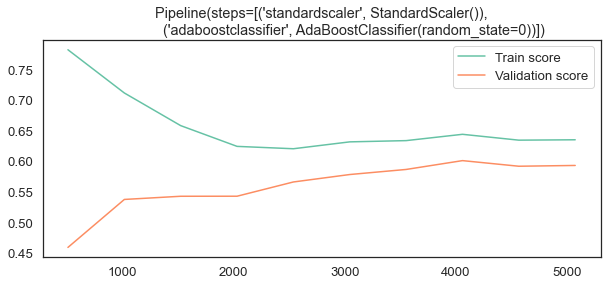

In [33]:
#loop through test models with evaluation function
for name, model in dict_of_models.items():
    
    print(name)
    evaluation(model)

> SVM performs the best. Let's see if we can tweak it further to get some better performance.

#### *Model Improvement*

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

> Let's start by checking if a different scaler could improve score.

In [35]:
# List of Scalers
scalers =  [MinMaxScaler(),
            MaxAbsScaler(),
            StandardScaler(),
            RobustScaler(),
            Normalizer(),
            QuantileTransformer(),
            PowerTransformer()]

In [36]:
# Checking the performance of scalers with model
for i in scalers:
    pipe = make_pipeline(i, SVC(random_state=0, gamma='auto'))
    pipe.fit(X_train, y_train)
    print(i, 'Score: ', pipe.score(X_test, y_test))

MinMaxScaler() Score:  0.571897570584373
MaxAbsScaler() Score:  0.571897570584373
StandardScaler() Score:  0.7964543663821405
RobustScaler() Score:  0.5738673670387393
Normalizer() Score:  0.571897570584373
QuantileTransformer() Score:  0.571897570584373
PowerTransformer() Score:  0.7951411687458962


In [37]:
# Difference between highest performer and previous scaler
qt = make_pipeline(QuantileTransformer(), SVC(random_state=0, gamma='auto'))
ss = make_pipeline(StandardScaler(), SVC(random_state=0, gamma='auto'))
qt.fit(X_train, y_train)
ss.fit(X_train, y_train)
print('Score Difference: ', qt.score(X_test, y_test) - ss.score(X_test, y_test))

Score Difference:  -0.22455679579776755


> Now let's adjust some parameters in attempt for some extra performance.

In [38]:
# Recreate pipeline with different test parameters
pipe = make_pipeline(QuantileTransformer(), SVC(random_state=0, degree=6, kernel='rbf', gamma='scale'))
pipe.fit(X_train, y_train)
print('Score: ', pipe.score(X_test, y_test))

Score:  0.804333552199606


> Tweaking the models paramters didn't provide any improvement. Every change was either worse or the same. Changing the scaler only provided a 0.008 increase in score.